# SYS 611: SimPy Inventory System (Object-oriented)

Paul T. Grogan <pgrogan@stevens.edu>

This example creates an inventory system simulation in SimPy using object-oriented concepts.

## Dependencies

This example is compatible with Python 2 environments through use of the `__future__` library function. Additionally, this example uses the `numpy`, `matplotlib.pyplot` and `simpy` libraries. SimPy is not a standard library included in most Python distributions. The `!pip install simpy` command below attempts to install it using the pip package management system.

In [1]:
# import the python3 behavior for importing, division, and printing in python2
from __future__ import absolute_import, division, print_function

# import the numpy package and refer to it as `np`
import numpy as np

# import the matplotlib pyplot package and refer to it as `plt`
import matplotlib.pyplot as plt

!pip install simpy

# import the simpy package
import simpy

## Simulation Model

Final balance: 34242.25


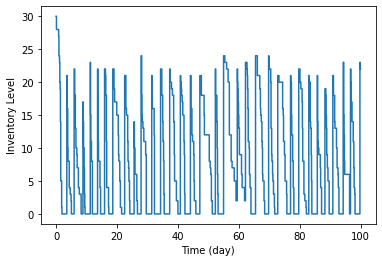

In [2]:
class Warehouse(object):
    def __init__(self, env, order_threshold, order_up_to):
        self.env = env
        self.order_threshold = order_threshold
        self.order_up_to = order_up_to
        
        self.inventory = order_up_to
        self.num_ordered = 0
        self.balance = 0
    
    def run(self):
        while True:
            # wait for the next arrival
            interarrival = np.random.exponential(1/5)
            yield env.timeout(interarrival)
            # subtract holding costs
            self.balance -= 2.00*self.inventory*interarrival
            # generate demand
            demand = np.random.randint(1, 4+1) 
            # handle demands
            if self.inventory > demand:
                num_sold = demand
            else:
                num_sold = self.inventory
            self.balance += 100.00*num_sold
            self.inventory -= num_sold

            # check for order
            if self.inventory < self.order_threshold and self.num_ordered == 0:
                quantity = self.order_up_to - self.inventory
                self.env.process(self.handle_order(quantity))

    def handle_order(self, quantity):
        self.num_ordered = quantity
        self.balance -= 50.00*quantity

        # wait for the delivery to arrive
        yield env.timeout(2)

        self.inventory += quantity
        self.num_ordered = 0

def observe(env, warehouse, obs_time, obs_inventory):
    while True:
        # record the observation time and queue length
        obs_time.append(env.now)
        obs_inventory.append(warehouse.inventory)
        # wait for the next 0.1 days
        yield env.timeout(0.1)

# create the simulation environment
env = simpy.Environment()

# create arrays to record data
obs_time = []
obs_inventory = []

warehouse = Warehouse(env, 10, 30)

# add the warehouse run process
env.process(warehouse.run())
# add the observation process
env.process(observe(env, warehouse, obs_time, obs_inventory))
# run the simulation for 100 days
env.run(until=100)

print('Final balance: {:.2f}'.format(warehouse.balance))

# plot the inventory over time
plt.figure()
plt.step(obs_time, obs_inventory, where='post')
plt.xlabel('Time (day)')
plt.ylabel('Inventory Level')
plt.show()

## Monte Carlo Simulation

To run a Monte Carlo simulation, all of the processes can be reused from the single simulation case.

In [3]:
NUM_RUNS = 10
# threshold inventory level to trigger an order (Q)
ORDER_THRESHOLD = 10
# inventory level to order up to (S)
ORDER_UP_TO = 30

# array to store outputs
BALANCE = []

for i in range(NUM_RUNS):
    # set the initial seed
    np.random.seed(i)
    
    # create the simulation environment
    env = simpy.Environment()

    # create arrays to record data
    obs_time = []
    obs_inventory = []

    warehouse = Warehouse(env, ORDER_THRESHOLD, ORDER_UP_TO)

    # add the warehouse run process
    env.process(warehouse.run())
    # add the observation process
    env.process(observe(env, warehouse, obs_time, obs_inventory))

    # run the simulation
    env.run(until=100)
    
    # record the final observed net revenue
    BALANCE.append(warehouse.balance)

# print final results to console
print('Net revenue balance for N={:} runs with Q={:} and S={:}:'.format(
        NUM_RUNS, ORDER_THRESHOLD, ORDER_UP_TO))
print('\n'.join('{:.2f}'.format(i) for i in BALANCE))

# write results to CSV file
import csv

with open('inventory.csv', 'w') as output:
    writer = csv.writer(output)
    writer.writerow(['Run', 'Final Balance'])
    for i, sample in enumerate(BALANCE):
        writer.writerow([i+1, sample])

Net revenue balance for N=10 runs with Q=10 and S=30:
33168.09
34697.14
35403.40
35246.47
33849.07
32932.41
33929.40
36137.91
35661.28
34766.71
